## <font color='red'>Time Evolution</font> 


In [1]:
from TFM_Granatiero_Utils.TFM_Pre_Process import *

In [2]:
data_full = pd.read_csv('../TFM_Granatiero_Data/week_01mar_30abr.csv', index_col=0)
restaurants_df = pd.read_csv('../TFM_Granatiero_Data/restaurants_Datos_Init_01_05_2021.csv', index_col=0)
data_full.shape

(458641, 9)

In [3]:
Score_Rules = {'CARD_SWIPE'         :{'LEFT':2, 'DOWN':4}, 
              'RESTAURANT_ACTION'   :{'delivery':5,'book_url':5,'chefInstagram':3,'instagram':3, 
                                      'menu':3,'website':3,'maps':3,'call':5, 'favourite_press':4, 
                                      'curated_by':3},
              'RESTAURANT_FAVOURITE':4,
              'view_item':3,
              'RESTAURANT_BLACKLISTED':1,
              'MY_FAVS_REMOVE_RESTAURANT':1}

pre = PreProcessing_Data(data_full, restaurants_df, Rules)
pre.init_simple_data()
pre.clean_anomalies(10, 1000)

## Defining some functions useful to inspect users beahviour with time

In [4]:
def h_conv(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 23):
        return'Night'
    elif (x <= 4):
        return'Late Night'
    
def user_day_date_activity(full_df):
    return full_df.pivot_table(values="event_timestamp", index="user_pseudo_id", columns="day_date", aggfunc=pd.Series.nunique).fillna(0)

def user_day_date_reservations(full_df):
    return full_df.pivot_table(values="consuming", index="user_pseudo_id", columns="day_date", aggfunc='sum').fillna(0)

def get_day_of_week_users_activity_df(full_df):
    dfs = []
    for i in full_df.week_number.unique():
        data_i = full_df[full_df.week_number==i]
        user_day_activity_i = data_i.pivot_table(values="event_timestamp", index="user_pseudo_id", columns="day", aggfunc=pd.Series.nunique).fillna(0)
        dfs.append(user_day_activity_i)
    return pd.concat(dfs, axis=1).fillna(0)

def get_user_week_stats(user_ps_id, day_date_df):
    ts         = day_date_df.loc[user_ps_id,:]
    ts.index   = pd.DatetimeIndex(ts.index)
    Week_list  = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
    means      = [ts.asfreq(day).mean() for day in Week_list] ; sds    = [ts.asfreq(day).std() for day in Week_list]
    means_id   = [i[2:]+'_mean' for i in Week_list]           ; sds_id = [i[2:]+'_sd' for i in Week_list]
    week_stats = pd.Series(means+sds, index=means_id+sds_id)
    return week_stats

def fit_Users_Week_df(day_date_df):
    all_users = set(day_date_df.index) 
    Week_list = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
    means_id  = [i[2:]+'_mean' for i in Week_list] ; sds_id = [i[2:]+'_sd' for i in Week_list]
    Users_Week_df = pd.DataFrame(index=all_users, columns=means_id+sds_id)
    for user in all_users:
        Users_Week_df.loc[user,:] = get_user_week_stats(user, day_date_df)
    
    Users_Week_df = Users_Week_df.apply(pd.to_numeric, downcast='float', errors='coerce')

    return Users_Week_df   

def check_mean_sd(Users_Week, min_mean = 5, max_sd = 9):
    users_day_max = Users_Week_df.iloc[:,0:7].idxmax(axis="columns")
    cols=['user_pseudo_id', 'user_day_max', 'mean', 'sd']
    reccomandable = pd.DataFrame(columns=cols)
    
    for user_ps_id in Users_Week.index: 
        if Users_Week.loc[user_ps_id,users_day_max[user_ps_id]] >= min_mean and \
                        Users_Week.loc[user_ps_id,users_day_max[user_ps_id][:3]+'_sd'] <= max_sd:
            user_data     = pd.DataFrame([[user_ps_id, users_day_max[user_ps_id][:3],\
                            Users_Week.loc[user_ps_id,users_day_max[user_ps_id]],\
                            Users_Week.loc[user_ps_id,users_day_max[user_ps_id][:3]+'_sd']]], columns=cols)
            reccomandable = pd.concat([reccomandable, user_data])
    
    return reccomandable

def is_consuming(x): 
    if x == 'book_url' or x == 'delivery' or x == 'call':
        return True
    else:
        return False
    
def get_user_series(user_ps_id):
    data_user = data[data.user_pseudo_id == user_ps_id]
    data_user = data_user.sort_values(by='event_timestamp')
    user_series = data_user.groupby('day_date').count().event_timestamp
    return user_series 

In [5]:
data=pre.simple_data

In [6]:
data = data.reset_index(drop=True)

data['date'] = pd.to_datetime(data['event_timestamp'], unit='us')
data['day']  = [day.weekday() for day in data['date']]
data['day_date']  = [day.date() for day in data['date']]
data['hour'] = [day.hour for day in data['date']]
data['session'] = [h_conv(h) for h in data['hour']]
data['week_number'] = [day.isocalendar()[1] for day in data.day_date]
data['consuming'] =[is_consuming(data.action_string_value.loc[i]) for i in data.index]


In [8]:
data.head()

,user_id,name_string_value,event_name,event_timestamp,action_string_value,dir_string_value,user_pseudo_id,restaurant_id,date,day,day_date,hour,session,week_number,consuming
0,30,BiBo Madrid,view_item,1615155298969713,NaN,NaN,866B9EE01027478983F57B8BD1BF7A90,110,2021-03-07 22:14:58.969713,6,2021-03-07,22,Night,9,False
1,3,BiBo Madrid,CARD_SWIPE,1615138858387133,NaN,LEFT,B17DBAF19BF2470EB1B1FA804F262B5A,110,2021-03-07 17:40:58.387133,6,2021-03-07,17,Eve,9,False
2,34,BiBo Madrid,CARD_SWIPE,1615084140200370,NaN,LEFT,300C189433164EF698E191BBB176E943,110,2021-03-07 02:29:00.200370,6,2021-03-07,2,Late Night,9,False
3,8,BiBo Madrid,CARD_SWIPE,1615072969353229,NaN,LEFT,CF13A3DE17E846ADBB8F88759534AC59,110,2021-03-06 23:22:49.353229,5,2021-03-06,23,Night,9,False
4,9,BiBo Madrid,CARD_SWIPE,1615107646883430,NaN,LEFT,A891C11FDF9A405F9CC0CC8D9D75550B,110,2021-03-07 09:00:46.883430,6,2021-03-07,9,Morning,9,False


Inspecting user interaction during the week

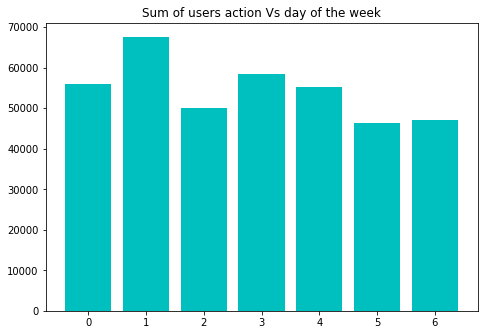

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
days = data['day'].value_counts().index
counts = data['day'].value_counts().values
ax.bar(days,counts,color='c')
plt.title('Sum of users action Vs day of the week', loc='center', pad=None)
plt.show()

In [15]:
data['day'].value_counts()

1    67646
3    58425
0    56029
4    55113
2    49961
6    47170
5    46244
Name: day, dtype: int64

Inspecting user interaction during hour of the day

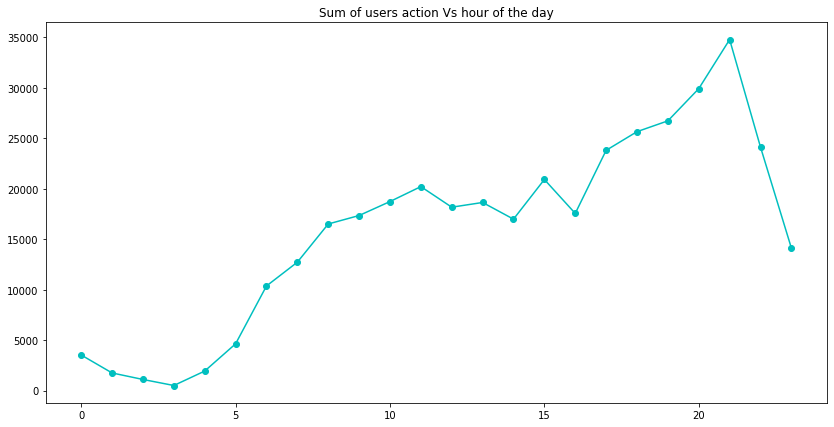

In [103]:
hour = data['hour'].value_counts().sort_index().index
counts = data['hour'].value_counts().sort_index().values

plt.figure(figsize=(14,7))

plt.plot(hour,counts,color='c',marker='o')

plt.title('Sum of users action Vs hour of the day', loc='center', pad=None)
#plt.savefig('TFM_figures/Mean_User_Actions_Per_Hour.jpg', dpi=300, bbox_inches="tight")

plt.show()

### Inspecting reservation, call and delivery activity

In [17]:
data.consuming.value_counts()

False    377231
True       3357
Name: consuming, dtype: int64

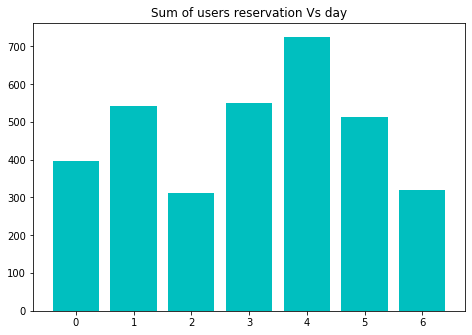

In [18]:
user_day_consume = data.pivot_table(values="consuming", index="user_pseudo_id", columns="day", aggfunc=pd.Series.sum).fillna(0)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
days = user_day_consume.sum(axis=0).index
counts = user_day_consume.sum(axis=0).values
ax.bar(days,counts,color='c')
plt.title('Sum of users reservation Vs day', loc='center', pad=None)
plt.show()


Considering each u/r couple only once

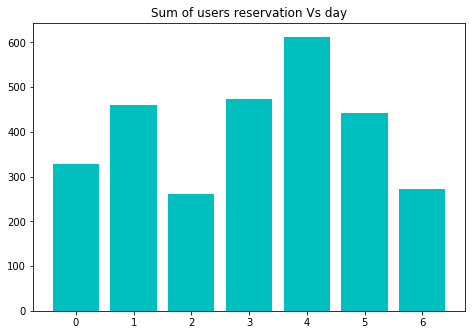

In [39]:
consume_no_ur_duplicate = data[data.consuming==True].loc[:,['consuming','day_date','user_id','day', 'restaurant_id']].drop_duplicates()

user_day_consume = consume_no_ur_duplicate.pivot_table(values="consuming", index="user_id", columns="day", aggfunc=pd.Series.sum).fillna(0)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
days = user_day_consume.sum(axis=0).index
counts = user_day_consume.sum(axis=0).values
ax.bar(days,counts,color='c')
plt.title('Sum of users reservation Vs day', loc='center', pad=None)
plt.show()

Considering one reservation a day

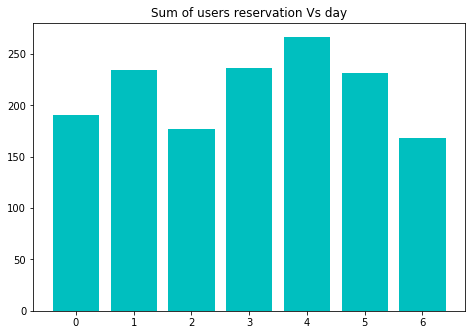

In [40]:
data_once_a_day = data[data.consuming==True].loc[:,['consuming','day_date','user_id','day']].drop_duplicates()

user_day_consume = data_once_a_day.pivot_table(values="consuming", index="user_id", columns="day", aggfunc=pd.Series.sum).fillna(0)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
days = user_day_consume.sum(axis=0).index
counts = user_day_consume.sum(axis=0).values
ax.bar(days,counts,color='c')
plt.title('Sum of users reservation Vs day', loc='center', pad=None)
plt.show()

Friday 18 users reserve twice and one reserve three times

In [51]:
user_day_consume.loc[:,4].value_counts()#.mean()

0.0    928
1.0    222
2.0     18
3.0      3
Name: 4, dtype: int64

Normalizing to get mean number of action and mean standard deviation: the mean is averaged over all user the average of each user for each day of the week. The same for the standard deviation

In [7]:
user_day_date_activity_df = user_day_date_activity(data)
user_day_date_activity_df.head()

day_date,2021-03-01,2021-03-02,2021-03-03,2021-03-04,2021-03-05,2021-03-06,2021-03-07,2021-03-08,2021-03-09,2021-03-10,...,2021-04-21,2021-04-22,2021-04-23,2021-04-24,2021-04-25,2021-04-26,2021-04-27,2021-04-28,2021-04-29,2021-04-30
user_pseudo_id,,,,,,,,,,,,,,,,,,,,,
0001bc5a54267ae122ffc305f0483687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0
0007DD6AA2C04951BA2B281CC047634F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00101F77DA4A466192B5A86D9420DF57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00168C90F23F4F678FE1055315F8AC3D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,261.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001BF406981A4BCC8E1ED9F4EAF0ADEE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,109.0,93.0,0.0,83.0,0.0


In [8]:
pd.set_option('display.max_columns', None)
day_of_week_users_activity_df=get_day_of_week_users_activity_df(data)
day_of_week_users_activity_df.head()

day,0,1,2,3,4,5,6,0,1,2,3,4,5,6,0,1,2,3,4,5,6,0,1,2,3,4,5,6,0,1,2,3,4,5,6,0,1,2,3,4,0,1,2,3,4,5,6,0,1,2,3,4,5,6,0,1,2,3,4,5,6
003d4c0a8ffde91d071af56bf4a5ac23,0.0,0.0,0.0,0.0,0.0,0.0,112.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
008F98390F7046B8B64399206F2D03FB,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,4.0,0.0
0092DFBB2862438B91E1A476FCE4941F,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
00B3521918B64C6380AA6D7FFCAF63A4,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01033e56d2676bef40790143f8c91774,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Example for a given user

In [23]:
get_user_week_stats('0007DD6AA2C04951BA2B281CC047634F',user_day_date_activity_df)

MON_mean     3.666667
TUE_mean     0.000000
WED_mean     0.000000
THU_mean     0.000000
FRI_mean     0.333333
SAT_mean    10.250000
SUN_mean     0.000000
MON_sd      11.000000
TUE_sd       0.000000
WED_sd       0.000000
THU_sd       0.000000
FRI_sd       1.000000
SAT_sd      28.991378
SUN_sd       0.000000
dtype: float64

In [9]:
Users_Week_df = fit_Users_Week_df(user_day_date_activity_df)
Users_Week_df.head()

,MON_mean,TUE_mean,WED_mean,THU_mean,FRI_mean,SAT_mean,SUN_mean,MON_sd,TUE_sd,WED_sd,THU_sd,FRI_sd,SAT_sd,SUN_sd
E6C050581E804CE5B67B08AFCADEC571,18.777779,0.000000,0.000000,0.0,0.000000,0.0,0.0,54.119724,0.000000,0.000000,0.0,0.000000,0.0,0.0
FC7BB32E3D234F4191C8B26DE4A80099,0.000000,0.000000,3.444444,0.0,0.000000,0.0,0.0,0.000000,0.000000,10.333333,0.0,0.000000,0.0,0.0
cb073c1ba42c24f5ea723107ce92e282,0.000000,9.222222,0.000000,0.0,0.000000,0.0,0.0,0.000000,27.666666,0.000000,0.0,0.000000,0.0,0.0
86c436f7250ca2661a5b2a5bf0926ed6,0.000000,1.000000,0.000000,0.0,4.888889,0.0,0.0,0.000000,3.000000,0.000000,0.0,14.666667,0.0,0.0
04DC82A8CA66423895F927D51ED4BBE1,0.000000,0.000000,0.000000,0.0,8.222222,0.0,0.0,0.000000,0.000000,0.000000,0.0,22.504320,0.0,0.0


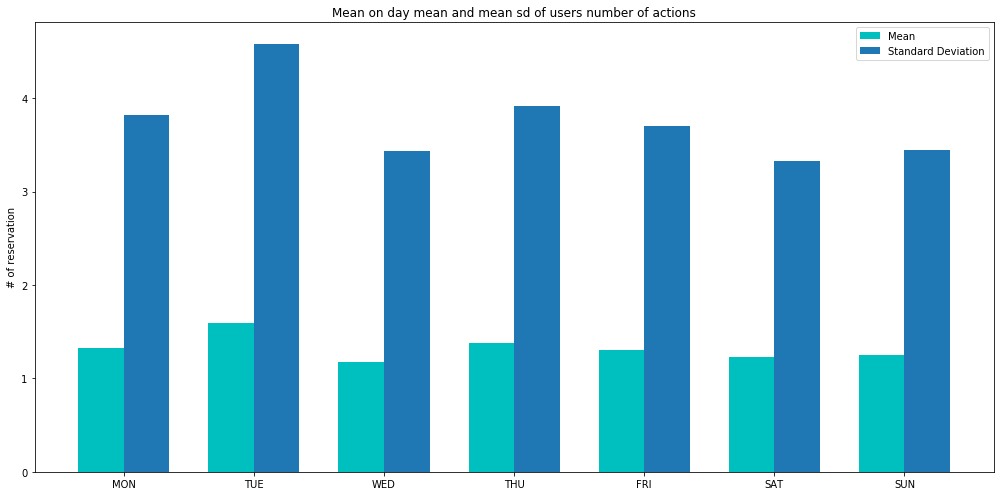

In [86]:
labels = [s[:3] for s in Users_Week_df.mean(axis=0)[7:].index]
means = Users_Week_df.mean(axis=0)[:7].values
sds = Users_Week_df.mean(axis=0)[7:].values

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(figsize=(14,7))
rects1 = ax.bar(x - width/2, means, width, label='Mean', color='c')
rects2 = ax.bar(x + width/2, sds, width, label='Standard Deviation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of reservation')
ax.set_title('Mean on day mean and mean sd of users number of actions')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
#plt.savefig('TFM_figures/Mean_User_Actions_Per_Day.jpg', dpi=300, bbox_inches="tight")
plt.show()



#### With check_mean_sd we can filter users with a min mean number of action and a max standard deviation. Actually the data in this sense are a bit poor.

We can see that almost all the frequency is still in one day. For example for: min_mean = 2, max_sd = 5

In [10]:
check_mean_sd(Users_Week_df, min_mean = 2, max_sd = 5)

,user_pseudo_id,user_day_max,mean,sd
0,08CEE66FE0E441B8A8BC57414B1209D1,WED,2.000000,4.092676
0,11846e69462ad1135309e84d7339afb7,FRI,2.222222,4.657730
0,1D54CEC851734BAE8C02AD870FC93484,TUE,2.111111,4.371626
0,b4cfda06411634388843080fb076456e,THU,2.111111,4.255715


Searching in a grid

In [11]:
import itertools  
l = list(np.arange(1,11))
a = [l,l]
all_combo = list(itertools.product(*a))
time_thresh_df = pd.DataFrame(index=range(len(all_combo)),\
                                 columns=['min_mean', 'max_sd', '# observations'])
for i in range(len(all_combo)):
    time_thresh_df.loc[i,:] = [all_combo[i][0], all_combo[i][1], len(check_mean_sd(Users_Week_df,\
                                                        min_mean = all_combo[i][0], max_sd = all_combo[i][1]))]
    
    

In [12]:
pd.set_option('display.max_rows', None)

time_thresh_df

,min_mean,max_sd,# observations
0,1,1,0
1,1,2,0
2,1,3,25
3,1,4,392
4,1,5,742
5,1,6,1025
6,1,7,1280
7,1,8,1488
8,1,9,1686
9,1,10,1865


Normalizing to get mean number of reservation, call and delivery and mean standard deviation: the mean is averaged over all user the average of each user for each day of the week. The same for the standard deviation

In [55]:
user_day_date_reservations_df = user_day_date_reservations(data)
user_day_date_reservations_df.head()

day_date,2021-03-01,2021-03-02,2021-03-03,2021-03-04,2021-03-05,2021-03-06,2021-03-07,2021-03-08,2021-03-09,2021-03-10,2021-03-11,2021-03-12,2021-03-13,2021-03-14,2021-03-15,2021-03-16,2021-03-17,2021-03-18,2021-03-19,2021-03-20,2021-03-21,2021-03-22,2021-03-23,2021-03-24,2021-03-25,2021-03-26,2021-03-27,2021-03-28,2021-03-29,2021-03-30,2021-03-31,2021-04-01,2021-04-02,2021-04-03,2021-04-04,2021-04-05,2021-04-06,2021-04-07,2021-04-08,2021-04-09,2021-04-10,2021-04-11,2021-04-12,2021-04-13,2021-04-14,2021-04-15,2021-04-16,2021-04-17,2021-04-18,2021-04-19,2021-04-20,2021-04-21,2021-04-22,2021-04-23,2021-04-24,2021-04-25,2021-04-26,2021-04-27,2021-04-28,2021-04-29,2021-04-30
user_pseudo_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0001bc5a54267ae122ffc305f0483687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0007DD6AA2C04951BA2B281CC047634F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00101F77DA4A466192B5A86D9420DF57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00168C90F23F4F678FE1055315F8AC3D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001BF406981A4BCC8E1ED9F4EAF0ADEE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0


In [56]:
Users_Week_reservetaions_df = fit_Users_Week_df(user_day_date_reservations_df)
Users_Week_reservetaions_df.head()

,MON_mean,TUE_mean,WED_mean,THU_mean,FRI_mean,SAT_mean,SUN_mean,MON_sd,TUE_sd,WED_sd,THU_sd,FRI_sd,SAT_sd,SUN_sd
db86a47da397b1816743e7794270b538,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0
d13990a5d1dc060f5860bb0ef0f9f481,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
7897FC48BE3442F6B8E1FECFD8BD6B29,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
D86145E9C24648A3939082484269902D,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
F97B35DE89624A1E880AA7935BC3C5DC,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


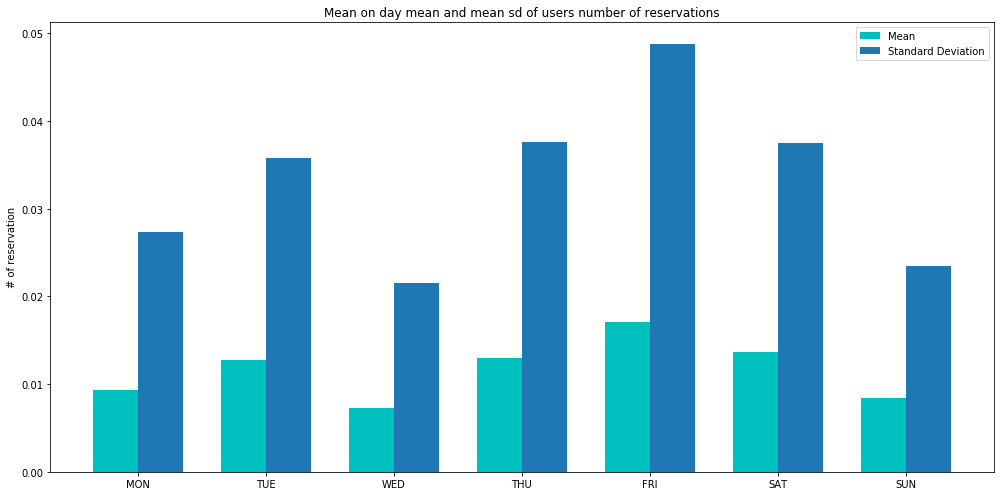

In [87]:
labels = [s[:3] for s in Users_Week_reservetaions_df.mean(axis=0)[7:].index]
means = Users_Week_reservetaions_df.mean(axis=0)[:7].values
sds = Users_Week_reservetaions_df.mean(axis=0)[7:].values

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14,7))
rects1 = ax.bar(x - width/2, means, width, label='Mean', color='c')
rects2 = ax.bar(x + width/2, sds, width, label='Standard Deviation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of reservation')
ax.set_title('Mean on day mean and mean sd of users number of reservations')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()
#plt.savefig('TFM_figures/Mean_User_Reservations_Per_Day.jpg', dpi=300, bbox_inches="tight")
plt.show()



## Time reccomender with multinomial dist., constant cut and reset in one month

In [59]:
from scipy.stats import multinomial

def constant_time_reccom(user_ps_id, reccomended_K, CUT):
    #initialize uniform prob 
    p = np.full(5,1/5)
    
    user_data = data[data.user_pseudo_id==user_ps_id]
    consumed_restaurnat = user_data[user_data.consuming==True].name_string_value.values
    
    #prob becomes half when user consumed in the past month
    for rest in consumed_restaurnat: 
        if rest in reccomended_K:
            p[reccomended_K.index(rest)] = CUT*p[reccomended_K.index(rest)]
    
    norm = np.linalg.norm(p, 1)
    p = p/norm
    #reccomending a restaurant with a multinomial dist
    suggested = reccomended_K[multinomial.rvs(1, p, size=1, random_state=None).argmax()]
    return p, suggested

In [60]:
reccom_1764    = ['Nomo Braganza', 'Asiakō', 'Umo', 'Sala de Despiece', 'LaKasa']
constant_time_reccom('91CA3C2D70754CE39F67F2E761E55FB8', reccom_1764, 0.5)

(array([0.125, 0.125, 0.25 , 0.25 , 0.25 ]), 'Umo')

## Time reccomender with multinomial dist., linear decreasing cut and learned delta

Building a daframe that gives the number of consecutive reservation for a given couple user/restaurant, the mean distance between two reservation and the last reservation instant

In [13]:
from datetime import timedelta

def single_user_reservation_df(u, full_data):
    user_data           = full_data[full_data.loc[:,'user_id']==u]
    user_reserved       = user_data[user_data['consuming']==True]
    restaurant_user_set = set(user_data[user_data['consuming']==True].restaurant_id)
    cols = ['user_id', 'number_of_reservations', 'mean_dist_reservations', 'last_reservation']
    full_user_restaurant_df  = pd.DataFrame(columns=cols)
    for rest in restaurant_user_set:
        user_restaurant_df     = user_reserved[user_reserved.restaurant_id==rest]
        number_of_reservations = len(user_restaurant_df)
        if number_of_reservations==1:
            #inf if there is just one reservation
            mean_dist_reservations = np.inf

        if number_of_reservations>1:
            #series of differences
            user_series_diff = pd.Series(np.sort(user_restaurant_df.day_date.values)).diff().dropna()
            #dropping anomalous reservations (different on same restaurant in the same day)
            user_series_diff = user_series_diff[user_series_diff!=timedelta(0)]
            if len(user_series_diff)==0:
                mean_dist_reservations = np.inf
                number_of_reservations = 1
            #taking the mean if there are more than one true reservation
            if len(user_series_diff)>0:
                mean_dist_reservations = user_series_diff.mean().days
                number_of_reservations = len(user_series_diff)+1
            if mean_dist_reservations==0:
                mean_dist_reservations=np.inf
                number_of_reservations = len(user_series_diff)+1
                
        last_reservation = user_restaurant_df.day_date.values[-1]
        full_user_restaurant_df.loc[rest,:] = [u, number_of_reservations, mean_dist_reservations, last_reservation]
    return full_user_restaurant_df

def get_reservation_time_df(full_data):
    all_users = set(full_data.user_id)
    user0     = list(all_users)[0]
    reservation_time_df = single_user_reservation_df(user0, full_data)

    for user in all_users - {user0}:
        reservation_time_df = pd.concat([reservation_time_df,single_user_reservation_df(user, full_data)])
    reservation_time_df.index = reservation_time_df.index.set_names(['restaurant_id']) 
    return reservation_time_df.reset_index() 
    

In [14]:
reservation_time_df = get_reservation_time_df(data)

In [15]:
reservation_time_df.head()

,restaurant_id,user_id,number_of_reservations,mean_dist_reservations,last_reservation
0,5,1,1,inf,2021-03-07
1,32,4,1,inf,2021-03-09
2,106,4,1,inf,2021-03-09
3,49,4,1,inf,2021-03-09
4,50,4,1,inf,2021-03-09


In [106]:
reservation_time_2_or_more = reservation_time_df[reservation_time_df.mean_dist_reservations!=np.inf]
reservation_time_2_or_more = reservation_time_2_or_more[reservation_time_2_or_more.mean_dist_reservations > 3]
print('There are {} users that reserved more than twice the same restaurant'.format(len(reservation_time_2_or_more)))

There are 99 users that reserved more than twice the same restaurant


Suppose to have for user and restaurant mu.

In [66]:
user_rest = reservation_time_df[reservation_time_df.user_id==4][reservation_time_df[reservation_time_df.user_id==4]\
                                                                .restaurant_id==193]



In [67]:
reservation_time_df[reservation_time_df.mean_dist_reservations!=np.inf].mean_dist_reservations.mean()


12.880952380952381

In [463]:
from datetime import date
from datetime import timedelta


def lambd(t,u,r,reservation_df):
    '''Train lambda for a given couple u/r'''
    user_rest_series = reservation_df[reservation_df.user_id==u][reservation_df[reservation_df.user_id==u].restaurant_id==r]
    t  = date.fromisoformat(t)
    t0 = user_rest_series.last_reservation.values[0]
    mu = user_rest_series.mean_dist_reservations.values[0]
    
    if mu == np.inf:
        reservation_user = reservation_df[reservation_df.loc[:,'user_id']==u].mean_dist_reservations
        reservation_res = reservation_df[reservation_df.loc[:,'restaurant_id']==r].mean_dist_reservations
        #if just one reservation takes user mean delta
        if reservation_user[reservation_user!=np.inf].mean() < np.inf:
            mu = reservation_user[reservation_user!=np.inf].mean()
        #if no user mean delta takes restaurant mean delta    
        elif reservation_res[reservation_res!=np.inf].mean() < np.inf:
            mu = reservation_res[reservation_res!=np.inf].mean()
        #else takes global mean
        else:
            mu = reservation_df[reservation_df.mean_dist_reservations!=np.inf].mean_dist_reservations.mean()
        
    if mu < np.inf:
        if t > t0 + timedelta(mu):
            return 1
    
        elif t0 <= t <= t0 + timedelta(mu):
            delta = t-t0
            return (1/mu)*(delta.days)
    
        elif t<t0:
            print('past date')
            return
        
def time_reccom(t, u, reccomended_K, reservation_df, full_data, restaurants_dictionary):
    '''Gives a dinamic recommendation given K static recomm and date'''
    #initialize uniform prob 
    p = np.full(5,1/5)
    
    user_data = full_data[full_data.user_id==u]
    consumed_restaurnat = user_data[user_data.consuming==True].name_string_value.values
    
    common_rest = set(consumed_restaurnat).intersection(set(reccomended_K))
    #depending from the last reservation it gives a reduced probability
    for rest in common_rest: 
        if rest in reccomended_K:
            rest_id = restaurants_dictionary[rest]
            p[reccomended_K.index(rest)] = lambd(t,u,rest_id,reservation_df)*p[reccomended_K.index(rest)]
    
    norm = np.linalg.norm(p, 1)
    p = p/norm
    #reccomending a restaurant with a multinomial dist
    suggested = reccomended_K[multinomial.rvs(1, p, size=1, random_state=None).argmax()]
    return p, suggested        


The output are the probabilities changed and the restaurant recommended

In [464]:
time_reccom('2021-03-30', 1764, reccom_1764, reservation_time_df, data, pre.restaurants_dictionary)

(array([0.05976096, 0.05876494, 0.2938247 , 0.2938247 , 0.2938247 ]),
 'Sala de Despiece')